# Training a neural network to predict total density using form factor
This notebook shows how a neural network can be trained to predict total density profiles from form factors.  
It contains the following steps: 
1) Download the data using the [NMR lipids API](https://nmrlipids.github.io/databankLibrary.html).  
2) Explore the data, and preprocess the data for the machine learning pipeline.  
3) Split data into train and test sets.
4) Train and evaluate the performance of the neural network. 

Variable descriptions from the [NMRlipids databank](https://nmrlipids.github.io/listOfFiles.html#):  
* Total densities: Total electron densities calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis units are nm and y-axis units e/nm3.  
* Form factors: X-ray scattering calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis value unit are Å-1 and y-axis value units are e/nm2.  

## Set up the environment, download the NMR lipids Database, and prepare the data

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from sklearn.model_selection import GridSearchCV

# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.python.keras.callbacks import EarlyStopping

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = (
    "3"  # Set TensorFlow verbosity to lowest (only print errors)
)

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [2]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

In [3]:
# # Initialize the NMR lipids databank
# databankPath = "./Databank/"  # this is the local path for the cloned Databank
# sys.path.insert(1, databankPath + "/Scripts/BuildDatabank/")
# from databankLibrary import *
# from new_functions import *

# systems = initialize_databank(databankPath)

In [4]:
# Initialize the NMR lipids databank
databankPath = "./Databank/"  # this is the local path for the cloned Databank

# Import functions defined in the NMRlipids databank
sys.path.insert(1, databankPath + "/Scripts/")
sys.path.insert(1, databankPath + "/Scripts/DatabankLib/")
from DatabankLib.plottings import *
from new_functions import *
from DatabankLib.core import initialize_databank

sys.path.insert(1, databankPath + "/Scripts/BuildDatabank/")
from databankLibrary import *

# Initialize the databank and stores the information of all simulations in a list called systems
# Each list item contains the information from the README.yaml file of the given simulation
systems = initialize_databank()

Databank initialized from the folder: /Users/even/NMRlipids/Databank/Data/Simulations


### Inclusion criteria
Systems are excluded if either of these occur:   
- There are warnings about:  
    - periodic boundary condition (PBC)  
    - or x-normal orientation  
- There is too little water in the simulation

In [5]:
# Some systems have periodic boundary condition (PBC) warnings and should be excluded from the analysis
PBC_warning_count = 0
xnormal_warning_count = 0
for system in systems:
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            PBC_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
        if (
            "ORIENTATION" in system["WARNINGS"].keys()
            and system["WARNINGS"]["ORIENTATION"] == "x-normal"
        ):
            xnormal_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
print("Number of systems with PBC warnings:", PBC_warning_count)
print("Number of systems with xnormal warnings:", xnormal_warning_count)

Number of systems with PBC warnings: 18
Number of systems with xnormal warnings: 3


In [6]:
# Exclude based on water/lipid ratio
water_to_lipid_ratio_threshold = 20
little_water_systems = 0
for system in systems:
    try:
        water_to_lipid_ratio = getHydrationLevel(system)
    except Exception:
        continue
    # print(water_to_lipid_ratio)
    if water_to_lipid_ratio <= water_to_lipid_ratio_threshold:
        little_water_systems += 1
print("Number of systems with too little water:", little_water_systems)

Number of systems with too little water: 34


In [7]:
# Count how many systems have long equilibration times
eq_time_threshold = 1
high_eq_times_counter = 0
for system in systems:
    eq_times = getEq_times(system, databankPath)
    if eq_times is not None and any(
        time > eq_time_threshold for time in eq_times.values()
    ):
        high_eq_times_counter += 1
        continue
print(
    "Number of systems with too high equilibration time for some lipid:",
    high_eq_times_counter,
)

Number of systems with too high equilibration time for some lipid: 317


Now we extract the form factor (ff) and total density (td) data of each simulation from the "system" variables.  
Each form factor has a shape of (1000), but the total densities have dimensions that vary.  
The total densities are split into separate lists td_x and td_y.  

In [8]:
system_ids = []
all_ff = []
all_td_x = []
all_td_y = []
td_x_lengths = []
td_y_lengths = []

# Complete data should have form factors of length 1000
required_form_factor_dimension = 1000

# Load form factors and total densities
for system in systems:
    # Exclude systems with warnings about periodic boundary conditions (PBC) or x-normal orientation watnings
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            continue  # Exclude system with PBC warnings and move to the next system
        elif (
            "ORIENTATION" in system["WARNINGS"].keys()
            and system["WARNINGS"]["ORIENTATION"] == "x-normal"
        ):
            continue  # Skip system with x-normal orientation warnings and move to the next system

    # Exclude systems with too low water to lipid ratio
    try:
        water_to_lipid_ratio = getHydrationLevel(system)
    except Exception:
        continue  # Exclude the system due to not having a recorded water to lipid ratio, and move to the next system
    if water_to_lipid_ratio <= water_to_lipid_ratio_threshold:
        continue  # Exclude this system due to having too low water to lipid ratio and move to the next system

    # Exclude systems with too long equilibration time for any lipid in eq_times
    eq_times = getEq_times(system, databankPath)
    if eq_times is None:
        pass  # The system is included due to lack of contraindication
    else:  # If any of lipid in the system has too high eq_times, exclude the system
        if any(time > eq_time_threshold for time in eq_times.values()):
            continue  # Exclude this system due to having too long equilibration time

    # Load form factor and total density for the systems that pass the inclusion criteria
    FFsim, TDsim = getFormFactorAndTotalDensityPair(system, databankPath)
    if (
        isinstance(FFsim, list)
        and isinstance(TDsim, list)
        and len(FFsim) == required_form_factor_dimension
    ):
        system_ids.append(system["ID"])  # Add system ID to the list

        ff = np.array([elem[1] for elem in FFsim])
        all_ff.append(ff)  # Add form factor to the list

        td_x = np.array([elem[0] for elem in TDsim])
        td_y = np.array([elem[1] for elem in TDsim])
        all_td_x.append(td_x)  # Add total density x values to the list
        all_td_y.append(td_y)  # Add total density y values to the list
        td_x_lengths.append(len(td_x))
        td_y_lengths.append(len(td_y))

assert (
    len(system_ids) == len(all_ff) == len(all_td_x) == len(all_td_y)
)  # Be sure that there are as many form factors as total densitiess
assert (
    td_x_lengths == td_y_lengths
)  # Be sure that dimensions of x and y values match for every simulation
N_experiments = len(all_ff)
print("Number of form factor and total density pairs:", N_experiments)

Number of form factor and total density pairs: 448


In [9]:
# Sort all lists by system id
system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths = [
    list(elem)
    for elem in zip(
        *sorted(zip(system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths))
    )
]

## Get to know the data

It is important to take the time to get to know what the data looks like.  
Plotting different views of the data can identify corrupted data, mislabeled data, or point towards subgroups or structure in the data that can be exploited.

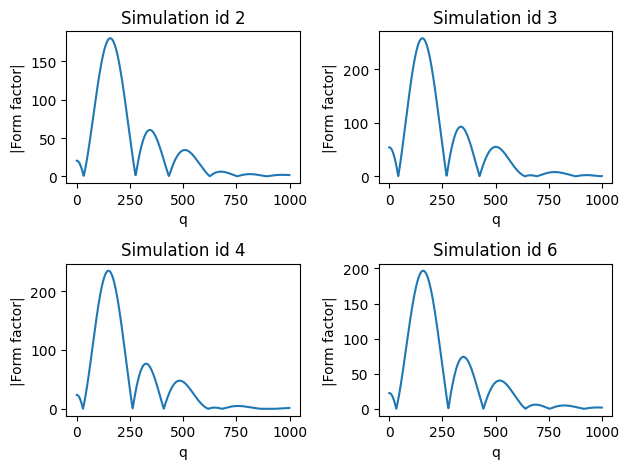

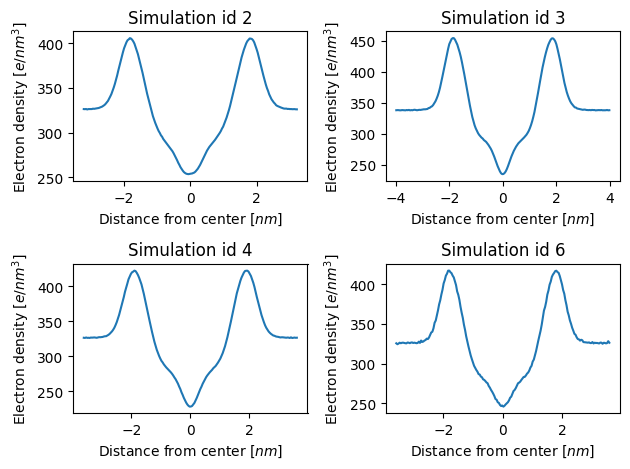

In [10]:
# Visualize form factors and total density profiles
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_plotting = 0

if "start_of_plotting" not in globals():
    start_of_plotting = 0

# Plot four density profiles
ff_fig, ff_axs = plt.subplots(nrows=2, ncols=2)
# plt.suptitle("Form factors of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
ff_axs = ff_axs.flatten()

td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
# plt.suptitle("Density profiles of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
td_axs = td_axs.flatten()

x_axis_label_ff = "q"
y_axis_label_ff = "|Form factor|"
x_axis_label_td = "Distance from center [" + r"$nm$" + "]"
y_axis_label_td = "Electron density [" + r"$e/nm^3$" + "]"


plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(
    zip(system_ids, all_td_x, all_td_y, all_ff)
):
    if plot_counter >= start_of_plotting:
        ff_axs[plot_index].plot(ff_vector)
        ff_axs[plot_index].set_title("Simulation id " + str(system_id))
        ff_axs[plot_index].set_xlabel(x_axis_label_ff)
        ff_axs[plot_index].set_ylabel(y_axis_label_ff)
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel(x_axis_label_td)
        td_axs[plot_index].set_ylabel(y_axis_label_td)
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting = plot_counter + 1
            break
ff_fig.tight_layout()
td_fig.tight_layout()

Looking through the simulations reveals the following facts about the data: 
- Some total densities are more smooth than others. 
- The x axis range of the total densities varies between simulations.
- Most density profiles have flat "shoulders", but not all: Some seem to be truncated in the x direction.

In [11]:
# Find the systems with narrow x dimension
narrow_limit = 3.0
narrow_td_system_ids = []
for system_id, x_vector, y_vector, ff_vector in zip(
    system_ids, all_td_x, all_td_y, all_ff
):
    if max(x_vector) < narrow_limit:
        narrow_td_system_ids.append(system_id)
print("Number of systems with narrow total densities:", len(narrow_td_system_ids))
print("IDs of systems with narrow total densities:", narrow_td_system_ids)

# Print the water/lipid ratio of the narrow systems
narrow_water_to_lipid_ratios = []
for system in systems:
    if system["ID"] in narrow_td_system_ids:
        try:
            water_to_lipid_ratio = getHydrationLevel(system)
        except Exception:
            continue
        narrow_water_to_lipid_ratios.append(int(water_to_lipid_ratio))
        print(
            "System with ID",
            system["ID"],
            "has a water/lipid ratio of",
            water_to_lipid_ratio,
        )

Number of systems with narrow total densities: 4
IDs of systems with narrow total densities: [147, 158, 224, 277]
System with ID 224 has a water/lipid ratio of 31.5625
System with ID 158 has a water/lipid ratio of 31.09722222222222
System with ID 277 has a water/lipid ratio of 28.0
System with ID 147 has a water/lipid ratio of 28.5546875


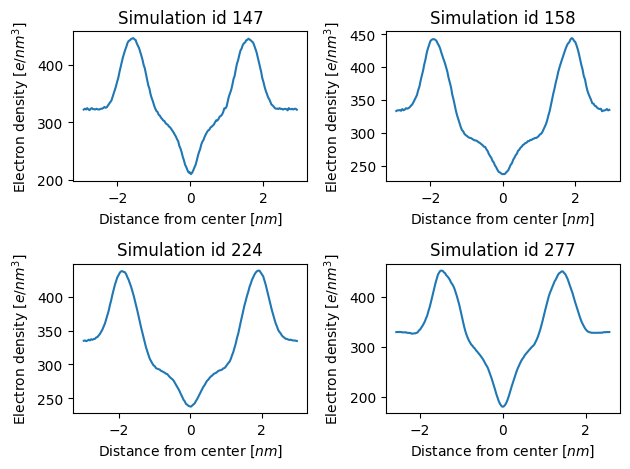

In [12]:
# Visualize the narrow systems
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_plotting_narrow_systems = 0

if "start_of_plotting_narrow_systems" not in globals():
    start_of_plotting_narrow_systems = 0

# Plot four density profiles
td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
td_axs = td_axs.flatten()

plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(
    zip(system_ids, all_td_x, all_td_y, all_ff)
):
    if (
        system_id in narrow_td_system_ids
        and plot_counter >= start_of_plotting_narrow_systems
    ):
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel(x_axis_label_td)
        td_axs[plot_index].set_ylabel(y_axis_label_td)
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting_narrow_systems = plot_counter + 1
            break
td_fig.tight_layout()

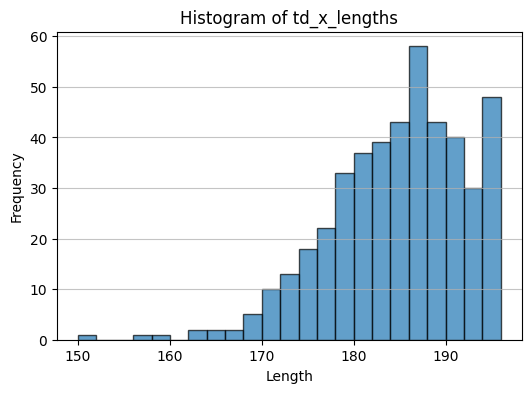

Every td_x length present in the dataset: {150, 156, 158, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196}
(The lenght of td_y matches td_x for each simulation)


In [13]:
# Visualize that the length of the total density data varies between simulations
plt.figure(figsize=(6, 4))
plt.hist(td_x_lengths, bins=23, edgecolor="black", alpha=0.7)
plt.title("Histogram of td_x_lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()
print("Every td_x length present in the dataset:", set(td_x_lengths))
print("(The lenght of td_y matches td_x for each simulation)")

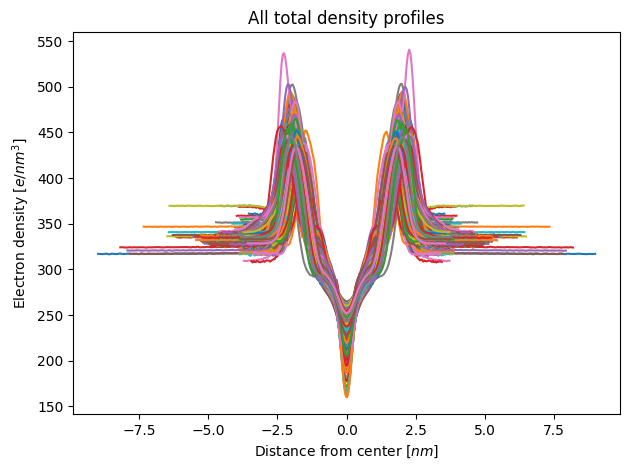

In [14]:
# Plot all total density profiles together
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, all_td_x, all_td_y, x_axis_label_td, y_axis_label_td
)
plt.title("All total density profiles")
plt.tight_layout()
plt.show()

## Homogenize the data format of the total densities

The histogram of td_x_lengths shows that the different simulations have different numbers of observed values.  
Furthermore, the plot of total densities shows that some total densities have long flat tails while others are seemingly truncated in the x direction.  
Since the model fitting requires data with a uniform format, a preprocessing process is needed to define a common x grid for the density profiles.  

To select the x interval, one option is to constrict the x range to the most narrow observed experiment, but this leads to a loss of information for the wider experiments.  
Aother option is to only include the widest experiments, but this also leads to a large loss of data.  
A compromise could be to trim the shoulders of the widest simulations, and extrapolate the narrowest simulations a bit. 

In the following code block, an x interval centered around zero is chosen.  
Experiments that are narrower than this interval are extrapolated in the x direction in a simple way: using the y values at the ends of the observation window.  
This makes sure that all experiments have either actual measurements or extrapolated values across the entire x interval.  

Next, a Gaussian Process Regression is used to interpolate (predict values between points) on a uniform set of x coordinates that cover the x interval.  
This brings all the data on the same format. 

In [15]:
# Define start and end of the common x interval
# Systems that are more narrow than this will be extrapolated in the x direction (not ideal), and wider systems truncated (not ideal but not less critical)
x_interval_end = (
    narrow_limit  # This could be something else instead, like e.g. 3.7. Try it out
)
x_interval_start = -x_interval_end
desired_length_of_padded_data = 400

padded_td_x = [
    extrapolate_X(td_x, desired_length_of_padded_data, x_interval_start, x_interval_end)
    for td_x in all_td_x
]
padded_td_y = [extrapolate_Y(td_y, desired_length_of_padded_data) for td_y in all_td_y]

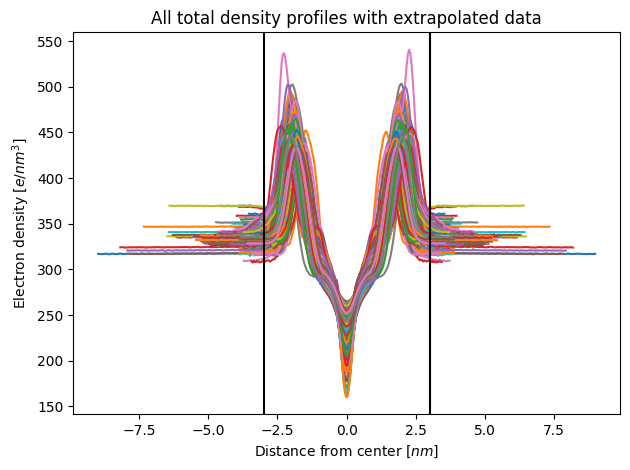

In [16]:
# Plot total density profiles
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax,
    padded_td_x,
    padded_td_y,
    x_axis_label_td,
    y_axis_label_td,
    lines=[x_interval_start, x_interval_end],
)
plt.title("All total density profiles with extrapolated data")
plt.tight_layout()
plt.show()

A Gaussian Process Regression is used to interpolate (predict values between points) on the uniform set of x coordinates.

In [17]:
# Interpolate with a Gaussian Process Regression to achieve a uniform x grid
uniform_x_range_dimension = 200

# Define the points for prediction
uniform_x_range = np.linspace(
    x_interval_start, x_interval_end, uniform_x_range_dimension
).reshape(-1, 1)

# Interpolate y values on the uniform x grid using Gaussian Process Regression (GPR)
standardized_y = interpolate_with_GPR(padded_td_x, padded_td_y, uniform_x_range)

Gather form factors and total densities in data frames.

In [18]:
# Convert the data to a pandas DataFrame and add the system_ids as index
sim_FF_df = pd.DataFrame(all_ff, index=system_ids)
sim_TD_y_df = pd.DataFrame(standardized_y, index=system_ids)

Get to know the data at a glance by calling the df name in a code block.

In [19]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2,326.266578,326.411833,326.583927,326.654469,326.719208,326.883323,327.121062,327.375123,327.665451,328.041373,...,328.138210,327.695826,327.275158,326.966740,326.824885,326.780955,326.694364,326.524175,326.376109,326.333766
3,339.148213,339.392934,339.448878,339.426754,339.502555,339.772211,340.251317,340.894900,341.614284,342.308643,...,342.100462,341.517810,340.851015,340.265099,339.978941,339.905497,339.739569,339.331006,338.891614,338.736204
4,327.483384,327.871093,328.283284,328.522202,328.663921,328.964677,329.571175,330.425840,331.411707,332.513994,...,332.472104,331.463480,330.587144,329.875784,329.319064,328.840276,328.409860,328.075647,327.834734,327.579586
6,326.363234,325.979514,325.845321,326.015782,326.231217,326.387896,326.732446,327.404137,328.017799,328.055518,...,327.165854,326.621102,326.610947,326.763274,326.737705,326.475303,326.192410,326.135468,326.299401,326.419087
11,336.553344,336.740851,336.976415,337.320149,337.803471,338.402172,339.074996,339.830195,340.732055,341.849983,...,341.920072,340.776665,339.835907,339.055366,338.402534,337.850846,337.383891,337.001259,336.704447,336.476001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,338.938853,339.037322,339.322301,339.882920,340.533848,341.075154,341.535037,342.106718,342.901541,343.845970,...,343.591366,342.856296,342.199565,341.545737,340.923733,340.397932,339.989005,339.664993,339.378064,339.088166
805,328.435384,328.516308,328.621759,328.686770,328.735188,328.837918,329.012460,329.214385,329.418032,329.677170,...,329.867919,329.614788,329.401348,329.147152,328.870424,328.676977,328.628015,328.656803,328.640437,328.545051
808,332.873142,332.958645,333.134728,333.293765,333.376639,333.412907,333.450626,333.507114,333.586542,333.719420,...,333.856107,333.599327,333.377727,333.204998,333.097009,333.059743,333.079419,333.123394,333.149236,333.127293
814,328.621668,328.593424,328.539611,328.531178,328.598456,328.742804,328.943550,329.171678,329.427734,329.764939,...,329.776273,329.467810,329.253554,329.047822,328.834609,328.675799,328.620036,328.632639,328.632730,328.583223


### Plot all form factors and total densities

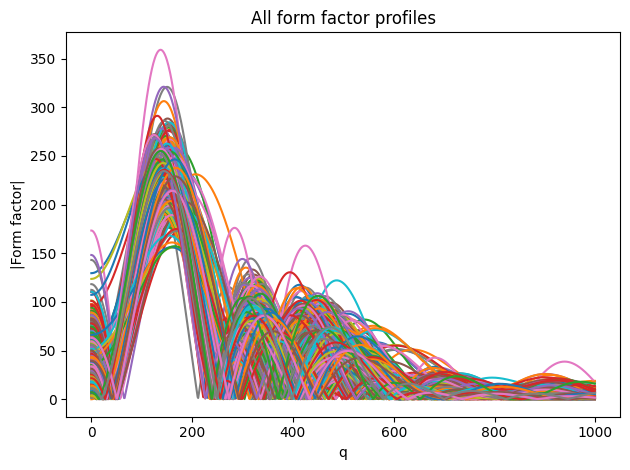

In [20]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, sim_FF_df, x_axis_label_ff, y_axis_label_ff)
plt.title("All form factor profiles")
plt.tight_layout()
plt.show()

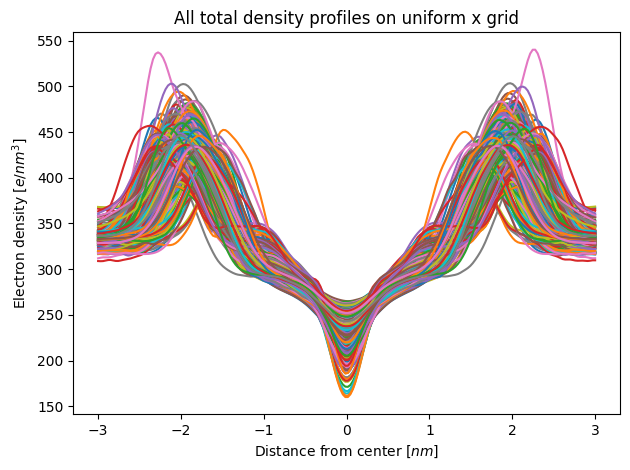

In [21]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, sim_TD_y_df, x_axis_label_td, y_axis_label_td
)
plt.title("All total density profiles on uniform x grid")
plt.tight_layout()
plt.show()

## Split data into train and test sets

The train/test split is highly influential on the model performance evaluation at the end of the notebook, as some cases are harder than other and are not considered if they end up in the train set.  
Therefore, to see how the models performance varies with the split, the split, model training and evaluation steps should be rerun with several different splits to get a better idea. 

In [22]:
train_input, test_input, train_output, test_output = train_test_split(
    sim_FF_df, sim_TD_y_df, test_size=0.2, random_state=rng.integers(0, 999999999)
)

n_train = train_input.shape[0]
n_test = test_input.shape[0]
print("n_train:", n_train)
print("n_test:", n_test)

n_train: 358
n_test: 90


In [23]:
# Rescale input and output to unit ranges using min and max values of the train set
min_ff_train = train_input.values.min()
max_ff_train = train_input.values.max()
train_input = rescale_to_zero_centered_unit_range(
    train_input, min_ff_train, max_ff_train
)
test_input = rescale_to_zero_centered_unit_range(test_input, min_ff_train, max_ff_train)

# Output
min_td_y_train = train_output.values.min()
max_td_y_train = train_output.values.max()
train_output = rescale_to_zero_centered_unit_range(
    train_output, min_td_y_train, max_td_y_train
)
test_output = rescale_to_zero_centered_unit_range(
    test_output, min_td_y_train, max_td_y_train
)

In [24]:
train_input

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
500,-0.299407,-0.299502,-0.299788,-0.300265,-0.300931,-0.301788,-0.302835,-0.304070,-0.305495,-0.307106,...,-0.485313,-0.485459,-0.485608,-0.485761,-0.485917,-0.486076,-0.486238,-0.486404,-0.486572,-0.486743
278,-0.375136,-0.375222,-0.375480,-0.375909,-0.376510,-0.377283,-0.378226,-0.379339,-0.380623,-0.382076,...,-0.485262,-0.485169,-0.485078,-0.484990,-0.484905,-0.484822,-0.484743,-0.484666,-0.484593,-0.484522
788,-0.392032,-0.392105,-0.392321,-0.392682,-0.393188,-0.393837,-0.394631,-0.395568,-0.396648,-0.397871,...,-0.486586,-0.486754,-0.486929,-0.487113,-0.487304,-0.487502,-0.487708,-0.487921,-0.488141,-0.488369
552,-0.410466,-0.410566,-0.410867,-0.411369,-0.412070,-0.412972,-0.414073,-0.415372,-0.416870,-0.418565,...,-0.476888,-0.477307,-0.477728,-0.478151,-0.478576,-0.479002,-0.479430,-0.479858,-0.480288,-0.480718
224,-0.475205,-0.475276,-0.475488,-0.475841,-0.476336,-0.476971,-0.477747,-0.478664,-0.479720,-0.480916,...,-0.497903,-0.497693,-0.497481,-0.497270,-0.497057,-0.496845,-0.496634,-0.496422,-0.496212,-0.496002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.328970,-0.329055,-0.329311,-0.329737,-0.330333,-0.331099,-0.332035,-0.333139,-0.334412,-0.335854,...,-0.490148,-0.490124,-0.490104,-0.490086,-0.490071,-0.490059,-0.490050,-0.490044,-0.490041,-0.490041
783,-0.412680,-0.412794,-0.413135,-0.413704,-0.414499,-0.415521,-0.416769,-0.418242,-0.419939,-0.421860,...,-0.484752,-0.484863,-0.484978,-0.485096,-0.485218,-0.485343,-0.485471,-0.485603,-0.485738,-0.485876
721,-0.268712,-0.268821,-0.269149,-0.269695,-0.270460,-0.271442,-0.272641,-0.274057,-0.275688,-0.277535,...,-0.488531,-0.489142,-0.489745,-0.490341,-0.490927,-0.491503,-0.492069,-0.492623,-0.493164,-0.493691
538,-0.336434,-0.336530,-0.336817,-0.337295,-0.337964,-0.338824,-0.339874,-0.341113,-0.342542,-0.344160,...,-0.495263,-0.495240,-0.495217,-0.495194,-0.495171,-0.495148,-0.495125,-0.495102,-0.495080,-0.495057


In [25]:
train_output

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
500,-0.052564,-0.051961,-0.050170,-0.048099,-0.046356,-0.044766,-0.042847,-0.040304,-0.036852,-0.032022,...,-0.031046,-0.034929,-0.039135,-0.042831,-0.045213,-0.046769,-0.048719,-0.051363,-0.053566,-0.054207
278,-0.045850,-0.044617,-0.044107,-0.044216,-0.044131,-0.043440,-0.042491,-0.041574,-0.040265,-0.037873,...,-0.038548,-0.040471,-0.041956,-0.043031,-0.043739,-0.044150,-0.044400,-0.044597,-0.044799,-0.045014
788,-0.044627,-0.044514,-0.044209,-0.044039,-0.044256,-0.044571,-0.044438,-0.043716,-0.042901,-0.042505,...,-0.042607,-0.042733,-0.043074,-0.043665,-0.044396,-0.044950,-0.044950,-0.044454,-0.044017,-0.044117
552,-0.038658,-0.036830,-0.034874,-0.033315,-0.031614,-0.028491,-0.023292,-0.016681,-0.009566,-0.001967,...,-0.003390,-0.011037,-0.017130,-0.022557,-0.027628,-0.031760,-0.034361,-0.035706,-0.036808,-0.038402
224,-0.039097,-0.038893,-0.039536,-0.040005,-0.038693,-0.036869,-0.035869,-0.035503,-0.035094,-0.034232,...,-0.034022,-0.035178,-0.035623,-0.035929,-0.036935,-0.038243,-0.038656,-0.038729,-0.039888,-0.040290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.051425,-0.051671,-0.051863,-0.051621,-0.050739,-0.049375,-0.047801,-0.046152,-0.044372,-0.042214,...,-0.042230,-0.044526,-0.046937,-0.048962,-0.050294,-0.051118,-0.051489,-0.051311,-0.050948,-0.051220
783,0.005352,0.008118,0.011362,0.015269,0.019469,0.023418,0.026975,0.030668,0.035278,0.041129,...,0.041844,0.036817,0.031532,0.026359,0.022298,0.019687,0.017681,0.015039,0.011434,0.007620
721,-0.049514,-0.047635,-0.045195,-0.042384,-0.039165,-0.035177,-0.030005,-0.023474,-0.015600,-0.006328,...,-0.007827,-0.017061,-0.024188,-0.030027,-0.035211,-0.039735,-0.043250,-0.045689,-0.047477,-0.049168
538,-0.035282,-0.035550,-0.035649,-0.035285,-0.034594,-0.033708,-0.032513,-0.030889,-0.028965,-0.026868,...,-0.027519,-0.029148,-0.030890,-0.032656,-0.033966,-0.034559,-0.034602,-0.034497,-0.034622,-0.035141


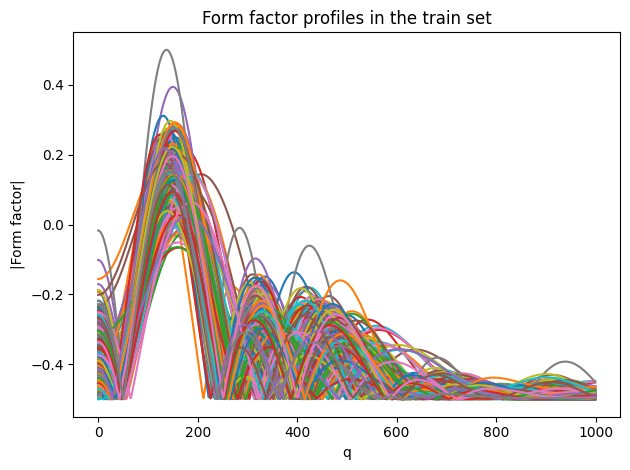

In [26]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, train_input, x_axis_label_ff, y_axis_label_ff)
plt.title("Form factor profiles in the train set")
plt.tight_layout()
plt.show()

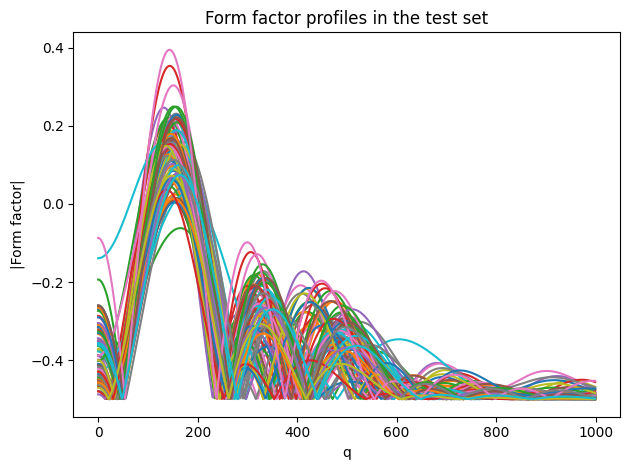

In [27]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, test_input, x_axis_label_ff, y_axis_label_ff)
plt.title("Form factor profiles in the test set")
plt.tight_layout()
plt.show()

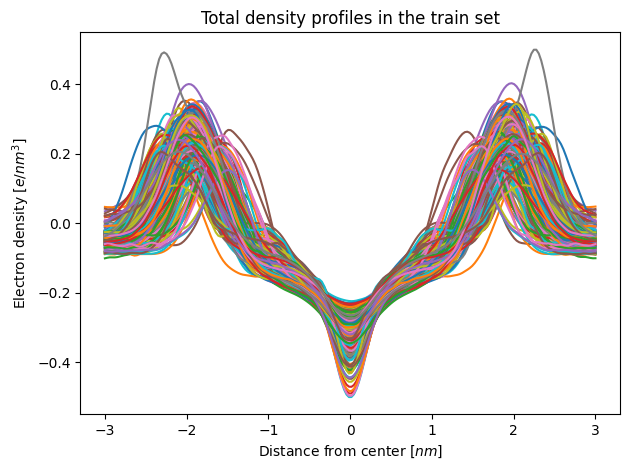

In [28]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, train_output, x_axis_label_td, y_axis_label_td
)
plt.title("Total density profiles in the train set")
plt.tight_layout()
plt.show()

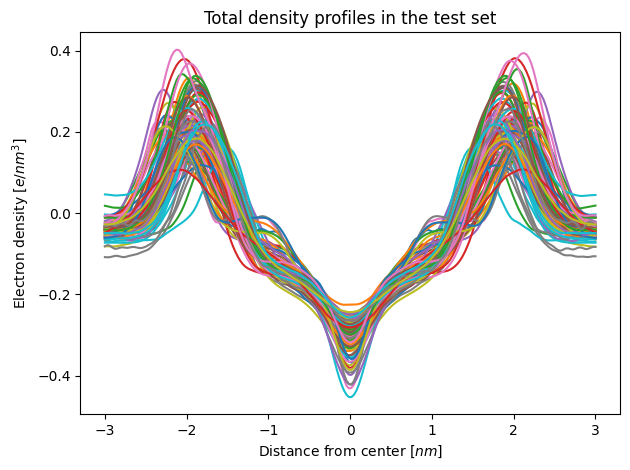

In [29]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, test_output, x_axis_label_td, y_axis_label_td
)
plt.title("Total density profiles in the test set")
plt.tight_layout()
plt.show()

## Define different neural network arhcitectures

Types of neural networks to compare:  
- Fully connected, with one or more hidden layers
- Convolutional network

In [30]:
def get_fully_connected_model(
    input_dim: int, hidden_layer_dims: tuple[int, ...], output_dim: int
) -> tf.keras.Model:
    """
    Returns a fully connected neural network Keras model.

    :param input_dim: Dimension of the input to the neural network.
    :param hidden_layer_dims: Tuple specifying the number of nodes in each hidden layer.
    :param output_dim: Dimension of the output of the neural network.

    :return: A fully connected neural network Keras model.
    """
    keras_input = keras.Input(shape=(input_dim,))
    x = keras_input

    # Create as many hidden layers as specified in hidden_layer_dims
    for dim in hidden_layer_dims:
        x = layers.Dense(dim, activation="relu")(x)

    # Final output layer
    output_layer = layers.Dense(output_dim, activation="linear")(x)

    model = tf.keras.Model(inputs=keras_input, outputs=output_layer)
    return model

In [31]:
def get_convolution_model(
    input_dim: int,
    output_dim: int,
    kernel_size: int = 3,
    activation_function: str = "relu",
) -> tf.keras.Model:
    """
    Returns a 1D convolutional neural network Keras model.

    This model assumes a single-channel 1D input of shape (input_dim, 1).
    It consists of two Conv1D + MaxPooling1D layers, followed by a flatten operation
    and a final dense layer for output.

    :param input_dim: The length of the input sequence.
    :param output_dim: Dimension of the output of the neural network.

    :return: A 1D convolutional neural network Keras model.
    """
    # Single-channel 1D input
    inputs = tf.keras.Input(shape=(input_dim, 1))

    # First convolution + max pooling
    x = layers.Conv1D(
        filters=32,
        kernel_size=kernel_size,
        padding="same",
        activation=activation_function,
    )(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Second convolution + max pooling
    x = layers.Conv1D(
        filters=64,
        kernel_size=kernel_size,
        padding="same",
        activation=activation_function,
    )(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Third convolution + max pooling
    x = layers.Conv1D(
        filters=64,
        kernel_size=kernel_size,
        padding="same",
        activation=activation_function,
    )(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Flatten and final dense layer
    x = layers.Flatten()(x)
    outputs = layers.Dense(output_dim, activation=None)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

Hyperparameters to explore: 
- Number of training epochs
- Loss function: Absolute error, squared error, combinations, adding a continuity loss 

In [32]:
# Define models
fully_connected_layers = (10000,)
fully_connected_model = get_fully_connected_model(
    input_dim=required_form_factor_dimension,
    hidden_layer_dims=fully_connected_layers,
    output_dim=uniform_x_range_dimension,
)

convolution_model = get_convolution_model(
    input_dim=required_form_factor_dimension,
    output_dim=uniform_x_range_dimension,
)

Compare the models by how many parameters they have.  
This gives a hint about how long it will take to train them. 

In [33]:
model = fully_connected_model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10000)          │    10,010,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │     2,000,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,010,200 (45.82 MB)

 Trainable params: 12,010,200 (45.82 MB)

 Non-trainable params: 0 (0.00 B)

## Train the neural network

The block below is a minimal example of training.

In [34]:
# Compile the model and choose the optimizer and loss function
model.compile(
    optimizer=tf.keras.optimizers.AdamW(amsgrad=True), loss="mean_absolute_error"
)

general_start_time = time.time()
history = model.fit(
    train_input,
    train_output,
    batch_size=128,
    epochs=1500,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", patience=100, restore_best_weights=True
        )
    ],
    verbose=1,
)

# Time use
general_end_time = time.time()
print("Used time: " + str(general_end_time - general_start_time) + " seconds")

Epoch 1/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.8512 - val_loss: 0.1490
Epoch 2/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1656 - val_loss: 0.1299
Epoch 3/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1207 - val_loss: 0.0865
Epoch 4/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0808 - val_loss: 0.0615
Epoch 5/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0547 - val_loss: 0.0449
Epoch 6/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0418 - val_loss: 0.0426
Epoch 7/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0399 - val_loss: 0.0395
Epoch 8/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0370 - val_loss: 0.0366
Epoch 9/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0341 - val_loss: 0.0343
Epoch 10/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0320 - val_loss: 0.0330
Epoch 11/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0321 - val_loss: 0.0313
Epoch 12/1500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0

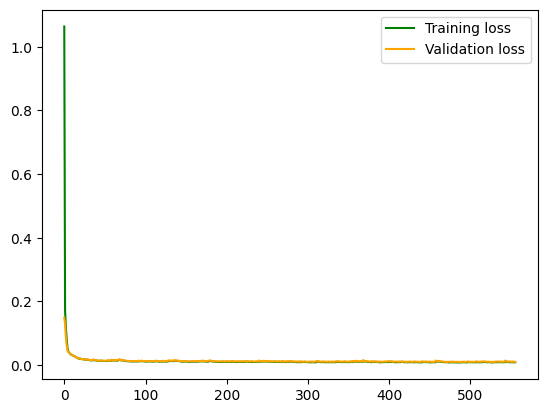

In [35]:
# Plot the training history of the model
fig, ax = plt.subplots()
ax = plot_training_trajectory(ax, history)
plt.show()

## Evaluate the neural network on the test set

Evaluate the network's performance by comparing predictions to true test case values.

### Visualize predictive accuracy by plotting truth and predictions together

In [36]:
predictions = pd.DataFrame(model.predict(test_input), index=test_output.index)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [37]:
true_scale_predictions = rescale_back_to_true_range(
    predictions, min_td_y_train, max_td_y_train
)
true_scale_predictions

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
462,334.447876,334.954529,334.056122,335.003845,334.442993,335.093323,334.765686,336.433105,335.391998,336.173096,...,336.507507,336.417053,335.410797,335.600708,335.864044,335.260437,335.185547,335.173645,334.299896,334.547150
48,331.917694,332.801208,331.768372,333.441162,333.351562,333.415100,333.236023,335.065277,335.011536,336.234650,...,335.873596,334.903870,334.256775,335.014282,334.606750,333.287109,332.806549,332.276245,332.201782,331.812195
742,333.692535,334.984222,334.430786,334.853394,334.264709,334.302063,333.639526,333.833008,333.668304,333.601593,...,334.291565,334.084290,334.230103,334.322906,334.574127,335.237793,334.473267,333.296356,334.544434,335.093262
481,328.813843,329.784241,329.784241,329.889069,329.616089,329.619019,329.756714,331.012238,330.339447,330.460541,...,331.018890,330.262512,329.690308,329.950562,330.719238,330.211548,329.483276,329.599854,328.800781,329.994873
229,333.024841,333.878784,332.658447,334.311829,334.644653,334.668762,334.600403,336.576874,335.987732,336.672791,...,337.190857,336.395447,335.091461,335.902466,336.031799,334.396912,334.067505,334.114807,333.237061,332.588348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,335.347290,336.422638,334.694550,336.094543,335.719604,335.687805,335.598938,337.426056,336.742950,336.755432,...,337.205750,337.286499,336.111328,336.883118,337.413269,336.245422,336.251190,336.707520,335.068878,334.842529
521,339.450867,339.030640,341.389832,342.133179,345.695740,349.085876,350.435425,348.665924,352.659393,357.642456,...,359.019287,357.016388,352.842468,348.552307,347.370087,345.184753,345.630310,345.345612,347.148743,342.305054
520,335.407959,335.717163,334.904175,335.799866,335.344086,335.984772,335.582581,336.614319,335.700378,336.124695,...,336.514038,336.703613,335.373474,335.931824,336.514160,335.939453,335.867920,336.044373,335.411469,335.089020
76,333.939819,335.588776,335.368866,335.745178,335.989136,336.273254,337.222900,339.089111,338.808350,338.932434,...,339.948669,338.911011,338.041138,337.402954,338.331116,336.967773,335.949738,335.682739,334.495453,335.247009


In [38]:
# Scale up again the output
true_scale_train_output = rescale_back_to_true_range(
    train_output, min_td_y_train, max_td_y_train
)
true_scale_test_output = rescale_back_to_true_range(
    test_output,
    min_td_y_train,
    max_td_y_train,  # Use min and max of train to scale up again, because they were used to scale down
)
true_scale_predictions = rescale_back_to_true_range(
    predictions, min_td_y_train, max_td_y_train
)

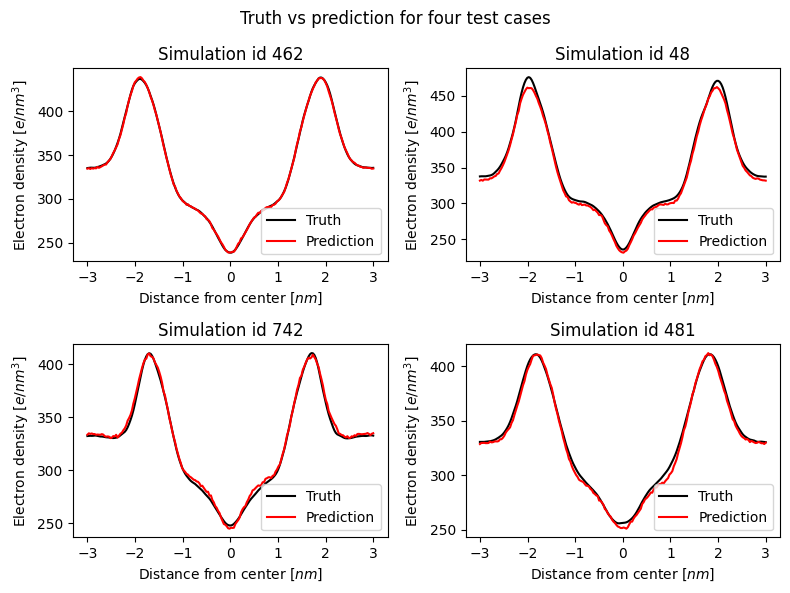

In [39]:
# Compare predictions to truth
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_test_case_plotting = 0

if "start_of_test_case_plotting" not in globals():
    start_of_test_case_plotting = 0

# Plot four comparisons
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()
plt.suptitle("Truth vs prediction for four test cases")
plot_index = 0
for system_counter, system_id in enumerate(true_scale_test_output.index):
    if system_counter >= start_of_test_case_plotting:
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_test_output.loc[[system_id]].values.flatten(),
            color="k",
            linestyle="-",
            label="Truth",
        )
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_predictions.loc[[system_id]].values.flatten(),
            color="r",
            linestyle="-",
            label="Prediction",
        )
        axs[plot_index].legend(loc="lower right")
        axs[plot_index].set_title("Simulation id " + str(system_id))
        axs[plot_index].set_xlabel(x_axis_label_td)
        axs[plot_index].set_ylabel(y_axis_label_td)

        plot_index += 1
        if plot_index >= 4:
            start_of_test_case_plotting = system_counter + 1
            break
fig.set_figheight(6)
fig.set_figwidth(8)
plt.tight_layout()
plt.show()

### Visualize predictive accuracy with the mean absolute deviation

In [40]:
prediction_residuals = [
    np.abs(
        true_scale_test_output.loc[[system_id]].values.flatten()
        - true_scale_predictions.loc[[system_id]].values.flatten()
    )
    for system_id in true_scale_test_output.index
]

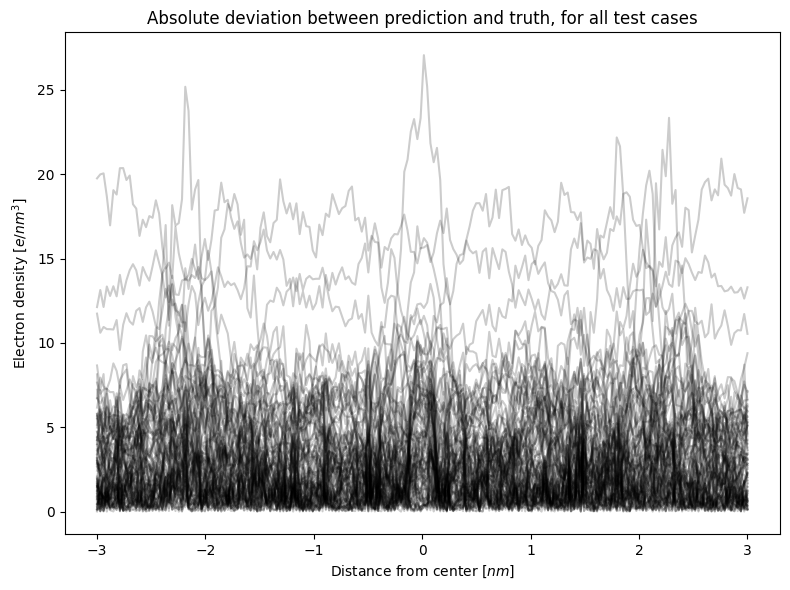

In [41]:
# Plot absolute deviation between prediction and truth for all test cases
test_indices_to_visualize = rng.integers(low=0, high=n_test, size=4)
fig, ax = plt.subplots()
for system_id in true_scale_test_output.index:
    ax.plot(
        uniform_x_range,
        np.abs(
            true_scale_test_output.loc[[system_id]].values.flatten()
            - true_scale_predictions.loc[[system_id]].values.flatten()
        ),
        color="k",
        linestyle="-",
        alpha=0.2,
    )
ax.set_xlabel(x_axis_label_td)
ax.set_ylabel(y_axis_label_td)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title("Absolute deviation between prediction and truth, for all test cases")
plt.tight_layout()
plt.show()

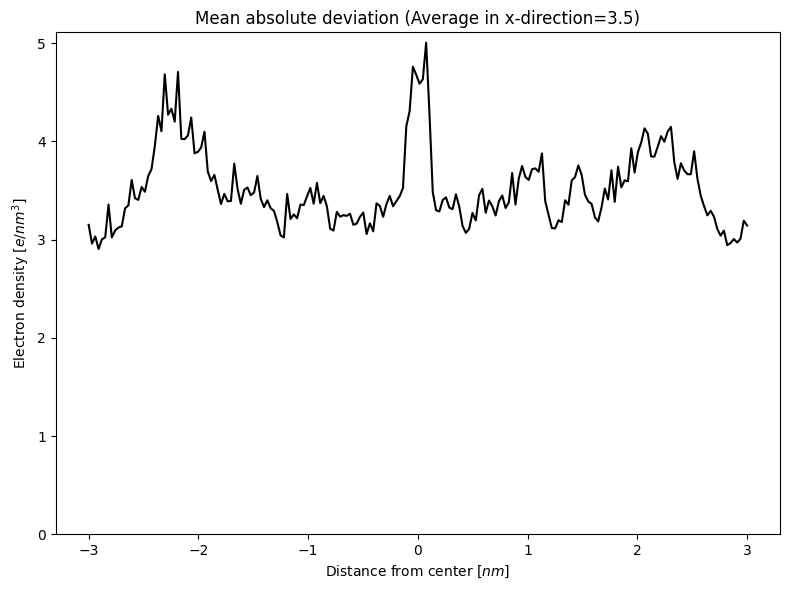

In [42]:
# Mean absolute deviation
mean_absolute_deviation = np.mean(
    prediction_residuals,
    axis=0,
)
fig, ax = plt.subplots()
ax.plot(
    uniform_x_range,
    mean_absolute_deviation,
    color="k",
    linestyle="-",
)
ax.set_xlabel(x_axis_label_td)
ax.set_ylabel(y_axis_label_td)
ax.set_ylim(bottom=0)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title(
    "Mean absolute deviation (Average in x-direction={:.1f})".format(
        np.mean(mean_absolute_deviation)
    )
)
plt.tight_layout()
plt.show()

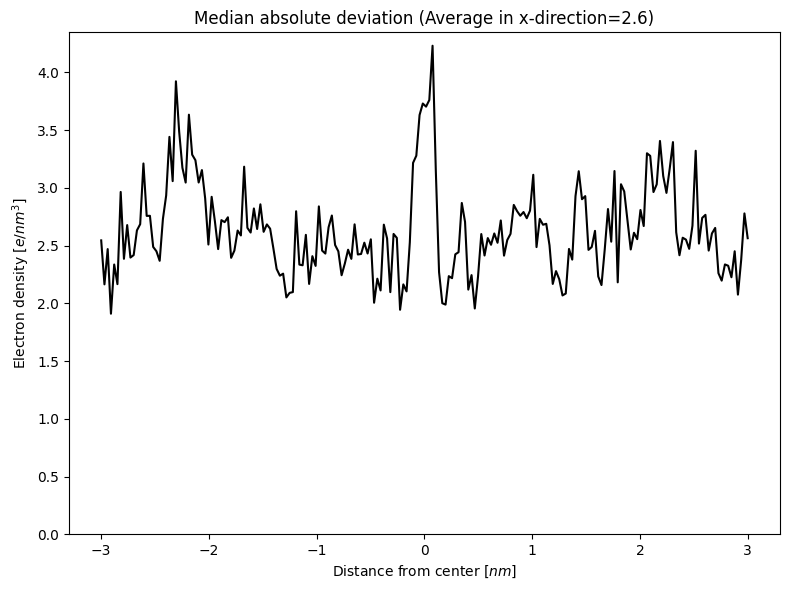

In [43]:
# Median absolute deviation
median_absolute_deviation = np.median(
    prediction_residuals,
    axis=0,
)
fig, ax = plt.subplots()
ax.plot(
    uniform_x_range,
    median_absolute_deviation,
    color="k",
    linestyle="-",
)
ax.set_xlabel(x_axis_label_td)
ax.set_ylabel(y_axis_label_td)
ax.set_ylim(bottom=0)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title(
    "Median absolute deviation (Average in x-direction={:.1f})".format(
        np.mean(median_absolute_deviation)
    )
)
plt.tight_layout()
plt.show()

## Future extensions

### Comparing models using cross validation
As mentioned above, the random train test split can have consequences for the model's performance.  
Therefore, when comparing models, it is important to use limit the impact of this randomness.  
One way of doing this is k-fold cross validation, where the data is split into k non-overlapping subsets (or folds). 
Models are compared by their average performance across the folds, using one fold as test set and the other as train set each time, and performance is measured using some predetermined metric like e.g. mean absolute deviation. 

### Realistic noise simulation 
Experimental form factors are typically more noisy for higher q values.  
Data augmentation strategies that add noise to input with a certain probability can improve the model's ability to tolerate noise. 

## Simulated noise

In experimental data, experimental noise in the form factors will make the prediction problem harder. To emulate this and explore how well the model would do in such cases, we can add noise to the form factors before making the prediction.  
Ideally, models should be compared based on how well they perform on noisy data. 

In [44]:
# Predict on noisy versions of input
noise_level = (
    0.1  # Compared to the input range of [-0.5, 0.5], 0.1 is a large amount of noise
)
noisy_test_input = test_input + noise_level * np.random.rand(*test_input.shape)
predictions_from_noisy_input = pd.DataFrame(
    model.predict(noisy_test_input), index=test_output.index
)

# Scale back to true range
true_scale_predictions_from_noisy_input = rescale_back_to_true_range(
    predictions_from_noisy_input, min_td_y_train, max_td_y_train
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


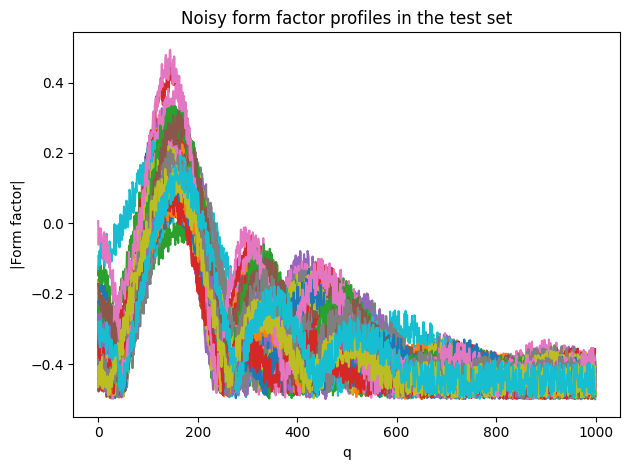

In [45]:
# Plot noisy form factors
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, noisy_test_input, x_axis_label_ff, y_axis_label_ff)
plt.title("Noisy form factor profiles in the test set")
plt.tight_layout()
plt.show()

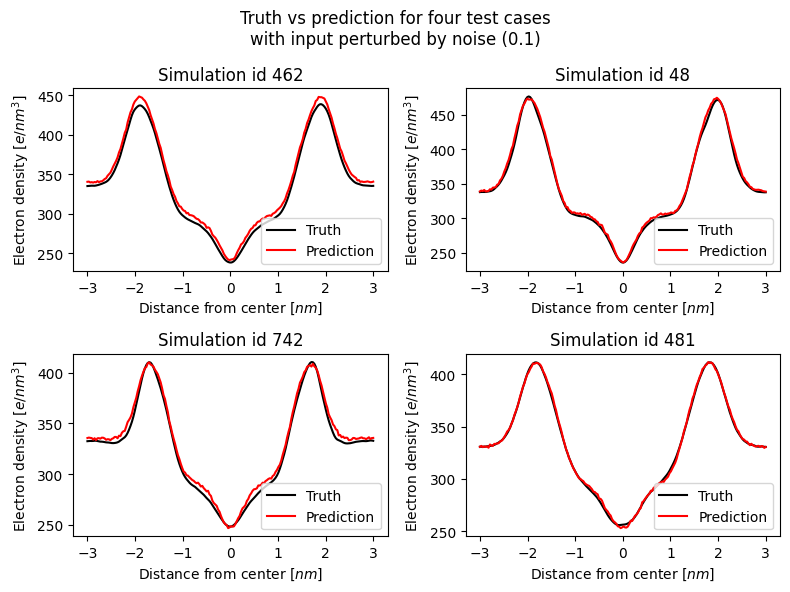

In [46]:
# Compare predictions to truth for test cases altered by noise
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_noise_altered_test_case_plotting = 0

if "start_of_noise_altered_test_case_plotting" not in globals():
    start_of_noise_altered_test_case_plotting = 0

# Plot four comparisons
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()
plt.suptitle(
    "Truth vs prediction for four test cases\nwith input perturbed by noise ({:.1f})".format(
        noise_level
    )
)
plot_index = 0
for system_counter, system_id in enumerate(true_scale_test_output.index):
    if system_counter >= start_of_noise_altered_test_case_plotting:
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_test_output.loc[[system_id]].values.flatten(),
            color="k",
            linestyle="-",
            label="Truth",
        )
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_predictions_from_noisy_input.loc[[system_id]].values.flatten(),
            color="r",
            linestyle="-",
            label="Prediction",
        )

        axs[plot_index].legend(loc="lower right")
        axs[plot_index].set_title("Simulation id " + str(system_id))
        axs[plot_index].set_xlabel(x_axis_label_td)
        axs[plot_index].set_ylabel(y_axis_label_td)

        plot_index += 1
        if plot_index >= 4:
            start_of_noise_altered_test_case_plotting = system_counter + 1
            break
fig.set_figheight(6)
fig.set_figwidth(8)
plt.tight_layout()
plt.show()